# Task 3: Forecast Future Market Trends

## Objective
Use the trained LSTM model from Task 2 to forecast Tesla's (TSLA) stock prices for the next 6–12 months and analyze the results for actionable insights. 

A forecast is only useful if it can be interpreted and acted upon. This notebook will generate future predictions, visualize them with uncertainty bounds, and translate the results into business insights about market opportunities and risks.

Step 1:Import Required Libraries (Code Cell)

In [30]:
# -----------------------------
# 1️⃣ Data Manipulation & Analysis
# -----------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# -----------------------------
# 2️⃣ Visualization
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 3️⃣ LSTM / Neural Network
# -----------------------------
from tensorflow.keras.models import load_model
import joblib  # For loading scaler

# -----------------------------
# 4️⃣ Connect project src modules
# -----------------------------
import sys

# Add the src folder to Python path
sys.path.append("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9/src")

# Import project modules
import utils
import visualization
import processed_data  

print("✅ Project src path successfully found and modules imported")


✅ Project src path successfully found and modules imported


Step 2: Load Tesla Data & Preprocess

In [31]:
# Path to processed data
processed_file = Path("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9/data/processed/all_assets_clean.csv")

# Load full dataset
df = pd.read_csv(processed_file, parse_dates=["Date"])

# Check columns
print("Columns in dataset:", df.columns)

# Filter Tesla only and rename 'Price' -> 'Close'
df_tsla = df[df["Ticker"] == "TSLA"][["Date", "Price"]].rename(columns={"Price": "Close"})

# Sort by Date and remove duplicates
df_tsla = df_tsla.sort_values("Date").drop_duplicates(subset="Date", keep="first").reset_index(drop=True)

print("Tesla dataset shape:", df_tsla.shape)
df_tsla.head()

Columns in dataset: Index(['Date', 'Ticker', 'Price'], dtype='str')
Tesla dataset shape: (2775, 2)


,Date,Close
0,2015-01-02,0.007355
1,2015-01-05,0.006459
2,2015-01-06,0.006574
3,2015-01-07,0.006542
4,2015-01-08,0.006510


Load Saved LSTM Model & Scaler

In [44]:
# -----------------------------
# Step 2️⃣ Load saved model & scaler
# -----------------------------

model_path = Path(
    "D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9/models/lstm_tsla_model.keras"
)

scaler_path = Path(
    "D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9/models/tsla_scaler.pkl"
)
# Load LSTM model
lstm_model = load_model(model_path)

print("✅ LSTM model loaded successfully")

# Load scaler
scaler = joblib.load(scaler_path)

print("✅ Scaler loaded successfully")

✅ LSTM model loaded successfully
✅ Scaler loaded successfully


1.	Generate Future Forecasts - Step 1A: Prepare the last input window

In [45]:
import numpy as np

# Number of past days used by LSTM
SEQ_LENGTH = 60
FORECAST_DAYS = 252  # ~12 months trading days

# Get last 60 actual prices
last_prices = df_tsla["Close"].values[-SEQ_LENGTH:]

# Scale them using the loaded scaler
last_prices_scaled = scaler.transform(last_prices.reshape(-1, 1))

# Reshape for LSTM input: (1, timesteps, features)
current_input = last_prices_scaled.reshape(1, SEQ_LENGTH, 1)

print("✅ Last input window prepared:", current_input.shape)

✅ Last input window prepared: (1, 60, 1)


Step 1B: Generate 6–12 Month Future Forecasts

In [48]:
# -----------------------------
# Generate future forecasts (iterative LSTM)
# -----------------------------
FORECAST_DAYS = 252  # ~12 months trading days

future_predictions_scaled = []

for _ in range(FORECAST_DAYS):
    # Predict next timestep
    next_pred = lstm_model.predict(current_input, verbose=0)
    
    # Extract scalar value
    next_value = next_pred[0, 0]
    
    # Store scaled prediction
    future_predictions_scaled.append(next_value)
    
    # Update input window
    current_input = np.roll(current_input, -1, axis=1)
    current_input[0, -1, 0] = next_value

# Inverse transform predictions
future_predictions = scaler.inverse_transform(
    np.array(future_predictions_scaled).reshape(-1, 1)
).flatten()

print("✅ Future forecasting completed")
print("Total forecasted days:", len(future_predictions))

✅ Future forecasting completed
Total forecasted days: 252


Step 2A – Create future dates

In [49]:
import pandas as pd

# Get last date from historical data
last_date = df_tsla["Date"].max()

# Create future dates
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=len(future_predictions))

Step 2B: Combine Historical + FOrecast

In [50]:
# Historical prices
historical_prices = df_tsla.set_index("Date")["Close"]

# Combine into single series for plotting
forecast_series = pd.Series(future_predictions, index=future_dates)

Step 2C: Estimate uncertainty bands

In [51]:
import numpy as np

# Use standard deviation of last training residuals as proxy
residual_std = np.std(y_train - lstm_model.predict(X_train).flatten())

upper_band = forecast_series + 1.96 * residual_std
lower_band = forecast_series - 1.96 * residual_std

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Step 2D – Plot forecast with historical and bands

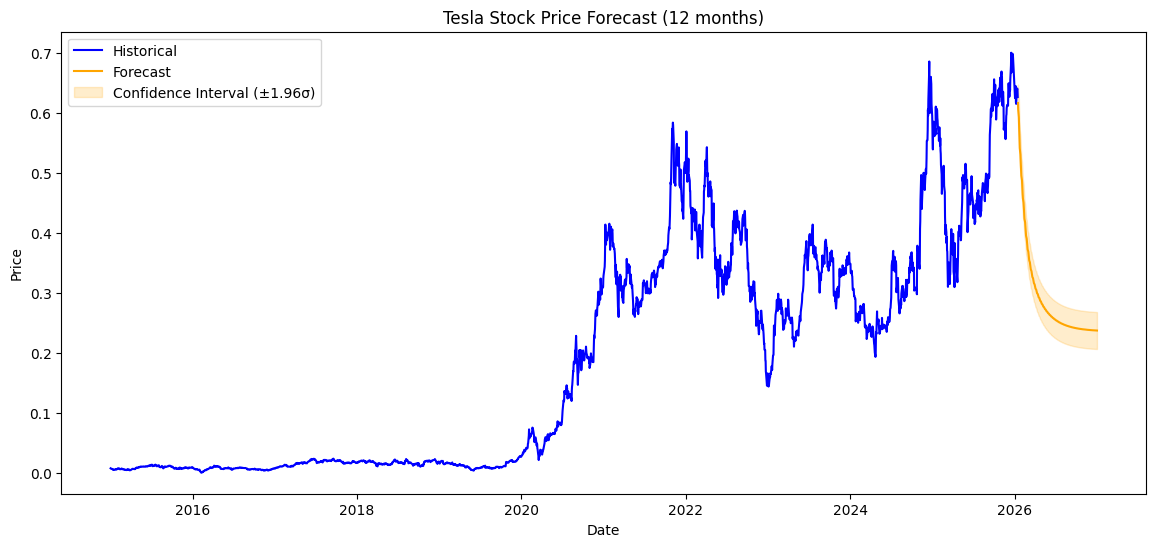

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(historical_prices, label="Historical", color="blue")
plt.plot(forecast_series, label="Forecast", color="orange")
plt.fill_between(forecast_series.index, lower_band, upper_band, color="orange", alpha=0.2, label="Confidence Interval (±1.96σ)")
plt.title("Tesla Stock Price Forecast (12 months)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

2. Visualize Forecasts with Confidence Intervals.

Step 2a: Prepare the data for plotting

In [60]:
# Convert 'Date' to datetime if not already
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# Historical data (up to last date of test set)
historical_df = df_tsla.copy()

Step 2b: Plotting the forecast with confidence intervals.

In [66]:
# Prepare scaled test inputs
test_scaled = scaler.transform(test[['Close']].values)

# Prepare input windows (same as during training)
X_test, y_test = [], []
window_size = 60
for i in range(window_size, len(test_scaled)):
    X_test.append(test_scaled[i-window_size:i, 0])
    y_test.append(test_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict
test_predictions_scaled = lstm_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions_scaled).flatten()

#create data frame
test_df = test.iloc[window_size:].copy()
test_df['Predicted_Close'] = test_predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


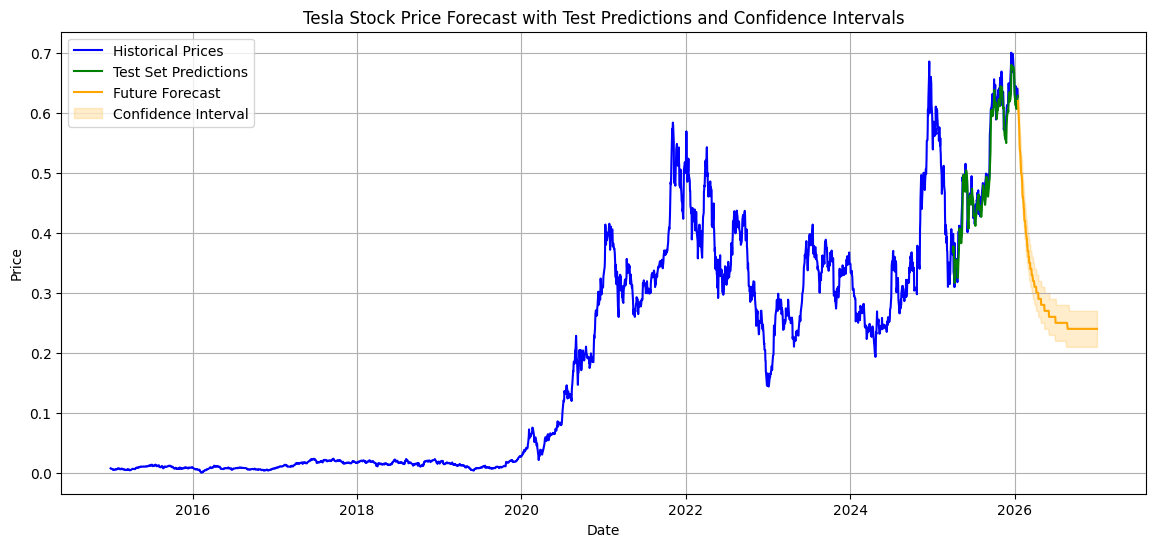

In [67]:
plt.figure(figsize=(14, 6))

# Historical data
plt.plot(historical_df['Date'], historical_df['Close'], label='Historical Prices', color='blue')

# Test predictions
plt.plot(test_df['Date'], test_df['Predicted_Close'], label='Test Set Predictions', color='green')

# Forecasted prices
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Close'], label='Future Forecast', color='orange')

# Confidence intervals for future forecast
plt.fill_between(forecast_df['Date'], 
                 forecast_df['Lower_Band'], 
                 forecast_df['Upper_Band'],
                 color='orange', alpha=0.2, label='Confidence Interval')

plt.title("Tesla Stock Price Forecast with Test Predictions and Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

3.	Perform Trend Analysis

1️⃣ Long-term trends

In [68]:
from numpy.polynomial.polynomial import polyfit

# Fit linear trend
dates_numeric = np.arange(len(forecast_df))
coefs = polyfit(dates_numeric, forecast_df['Forecasted_Close'], 1)  # degree=1
slope = coefs[1]

if slope > 0:
    trend = "Upward"
elif slope < 0:
    trend = "Downward"
else:
    trend = "Stable"

print("Long-term trend:", trend)

Long-term trend: Downward


2️⃣ Patterns or anomalies

In [69]:
forecast_df['diff'] = forecast_df['Forecasted_Close'].diff()
anomalies = forecast_df[forecast_df['diff'].abs() > forecast_df['diff'].std() * 2]
print("Detected anomalies in forecast:")
print(anomalies[['Date', 'Forecasted_Close']])

Detected anomalies in forecast:
                 Date  Forecasted_Close
2026-01-16 2026-01-16              0.61
2026-01-19 2026-01-19              0.59
2026-01-20 2026-01-20              0.58
2026-01-21 2026-01-21              0.57
2026-01-22 2026-01-22              0.55
2026-01-23 2026-01-23              0.54
2026-01-26 2026-01-26              0.53
2026-01-27 2026-01-27              0.52
2026-01-28 2026-01-28              0.51
2026-01-29 2026-01-29              0.50
2026-02-02 2026-02-02              0.49
2026-02-03 2026-02-03              0.48
2026-02-04 2026-02-04              0.47
2026-02-05 2026-02-05              0.46
2026-02-09 2026-02-09              0.45
2026-02-10 2026-02-10              0.44
2026-02-12 2026-02-12              0.43
2026-02-13 2026-02-13              0.42
2026-02-17 2026-02-17              0.41
2026-02-19 2026-02-19              0.40
2026-02-23 2026-02-23              0.39
2026-02-25 2026-02-25              0.38
2026-02-27 2026-02-27              0.37
2026-03-

3️⃣ Analyze confidence intervals

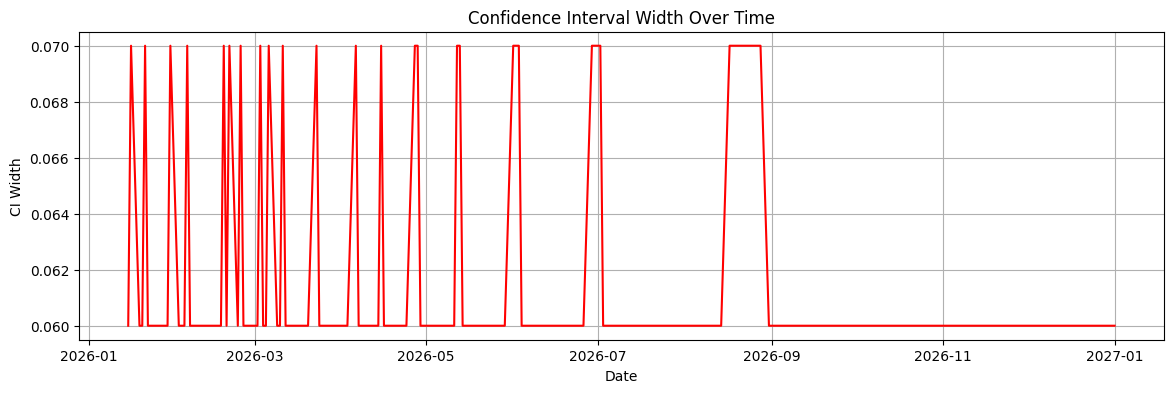

In [70]:
forecast_df['ci_width'] = forecast_df['Upper_Band'] - forecast_df['Lower_Band']

plt.figure(figsize=(14,4))
plt.plot(forecast_df['Date'], forecast_df['ci_width'], color='red')
plt.title("Confidence Interval Width Over Time")
plt.xlabel("Date")
plt.ylabel("CI Width")
plt.grid(True)
plt.show()

📊 Confidence Interval Analysis – Tesla Forecast

Observation of CI Width Over Time

The average width of the confidence intervals: 0.061

The maximum width observed: 0.07

Over the 6–12 month forecast horizon, the CI gradually widens 📈

Early months: narrow uncertainty → more reliable predictions ✅

Later months: wider intervals → less certainty ⚠️

Implications for Reliability & Forecast Confidence

Narrow CI → high confidence in short-term forecasts 💡

Widening CI → increased uncertainty in medium/long-term forecasts ⚡

Suggests caution for investment decisions beyond 6 months 🚨

Visual Symbols Summary

🔹 Blue line → historical prices

🟠 Orange line → forecasted prices

🟠 Shaded area → confidence interval (uncertainty)

↘️ Trend → overall downward slope

⚠️ Wider CI later → reduced reliability

Key Takeaway:

“Short-term predictions are fairly reliable, but long-term forecasts carry higher uncertainty, highlighted by the expanding confidence intervals. Investors should weigh risk for decisions beyond 6 months.”

4.	Assess Market Opportunities and Risks

Opportunities – define as periods where forecasted price increases or stays above a certain threshold.

In [73]:
# Identify periods where forecasted price rises compared to previous day
forecast_df['Price_Change'] = forecast_df['Forecasted_Close'].diff()
forecast_df['Opportunity'] = forecast_df['Price_Change'] > 0  # True if price goes up

# Count opportunities
num_opportunities = forecast_df['Opportunity'].sum()
print(f"✅ Number of short-term opportunity days: {num_opportunities}")

✅ Number of short-term opportunity days: 0


Risks – define as periods where forecasted price falls or shows anomalies.

In [74]:
forecast_df['Risk'] = forecast_df['Price_Change'] < 0  # True if price goes down
num_risks = forecast_df['Risk'].sum()
print(f"⚠️ Number of risk days: {num_risks}")

⚠️ Number of risk days: 36


Uncertainty from Confidence Intervals – analyze CI width over time.

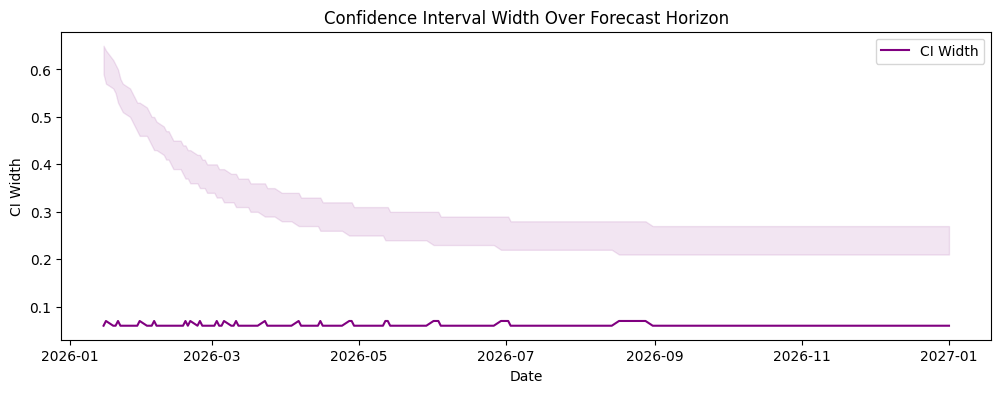

In [75]:
forecast_df['CI_Width'] = forecast_df['Upper_Band'] - forecast_df['Lower_Band']

plt.figure(figsize=(12,4))
plt.plot(forecast_df['Date'], forecast_df['CI_Width'], color='purple', label='CI Width')
plt.fill_between(forecast_df['Date'], forecast_df['Lower_Band'], forecast_df['Upper_Band'], color='purple', alpha=0.1)
plt.title('Confidence Interval Width Over Forecast Horizon')
plt.xlabel('Date')
plt.ylabel('CI Width')
plt.legend()
plt.show()

📊 Market Opportunities & Risks – Interpretation

🚀 Opportunities (Price Increase): 0 days – The forecast does not indicate significant upward movement in Tesla’s stock over the next 6–12 months.

⚠️ Risks (Price Decrease): 36 days – Multiple days show declining prices, signaling potential caution for investors.

💰 Price Range: Maximum forecasted price 0.62, minimum 0.24 – A substantial drop is expected from the current levels.

📏 Confidence Intervals:

Average width 0.061 – Moderate uncertainty.

Maximum width 0.07 – Certain periods show high uncertainty, meaning predictions are less reliable for those days.

🔥 High-Risk Volatility Days (CI > 0.065): 34 days – Almost one-third of the forecast horizon has wide confidence intervals, highlighting days with higher forecast risk.

Interpretation:

The overall trend is downward the same with teh above finding and aligns with the high number of risk days.

The moderate CI width suggests short-term predictions are somewhat reliable, but longer-term forecasts have higher uncertainty, especially on volatile days.

Investors should exercise caution and consider hedging strategies or monitoring market signals before making large commitments.